In [1]:
import paramiko
import os
import numpy as np
import struct

def connect_remote(hostname, port, username, private_key_path, passphrase=None):
    """建立远程服务器的SFTP连接"""
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())  # 自动接受未知主机密钥
    
    # 加载私钥
    private_key = paramiko.RSAKey.from_private_key_file(
        filename=private_key_path,
        password=passphrase
    )
    
    # 连接服务器
    ssh.connect(
        hostname=hostname,
        port=port,
        username=username,
        pkey=private_key,
        compress=True
    )
    print(f"已成功连接到远程服务器：{hostname}:{port}")
    return ssh.open_sftp()

def download_file(sftp, remote_path, local_dir):
    """
    下载远程文件到本地文件夹
    :param sftp: 已建立的SFTP客户端对象
    :param remote_path: 远程文件完整路径（如"/home/user/data/info"）
    :param local_dir: 本地保存文件夹（如"./local_data/"）
    :return: 本地文件完整路径（下载成功）或None（失败）
    """
    try:
        # 确保本地文件夹存在，不存在则创建
        os.makedirs(local_dir, exist_ok=True)
        
        # 提取远程文件名（如从"/home/user/data/info"中提取"info"）
        filename = os.path.basename(remote_path)
        local_path = os.path.join(local_dir, filename)  # 本地文件完整路径
        
        # 下载远程文件到本地
        sftp.get(remote_path, local_path)
        print(f"文件已下载到本地：{local_path}")
        return local_path
    
    except FileNotFoundError:
        print(f"远程文件不存在：{remote_path}")
        return None
    except paramiko.SSHException as e:
        print(f"SFTP下载失败：{str(e)}，远程文件：{remote_path}")
        return None
    except Exception as e:
        print(f"下载文件出错：{str(e)}，远程文件：{remote_path}")
        return None
    
def loadinfo(dir):
    fstr = dir + "info"
    fd = open(fstr,"rb")
    infocontent = fd.read()
    fd.close
    arr = struct.unpack("fIIIffffff", infocontent[:40])
    infoarr=np.zeros(6)
    infoarr[0] = arr[1]
    infoarr[1] = arr[2]
    infoarr[2] = arr[3]
    infoarr[3] = arr[6]
    infoarr[4] = arr[7]
    infoarr[5] = arr[8]
    print(infoarr)
    return infoarr


def loadSlice(dir,q,sl,nx,ny,nz,interval=11):
    fstr = dir + q + f"_{sl*interval}.gda"
    fd = open(fstr,"rb")
    fd.seek(0*4*sl*nx*ny*nz,1)
    arr = np.fromfile(fd,dtype=np.float32,count=nx*ny*nz)
    fd.close()
    arr = np.reshape(arr,(nz, ny, nx))
    arr = np.transpose(arr, axes=(2, 1, 0))
    return arr

In [2]:
import math
def find_nearest_lattice(r1, direction, l):
    """
    在三维格点中，找到沿指定方向、距离起始格点r1为l的最近格点。
    
    参数:
        r1 (tuple/list): 起始格点坐标，需为3个整数，如(1, 2, 3)
        direction (tuple/list): 方向向量，需为3个数字，如(1.0, 1.0, 0.0)
        l (float/int): 距离，需为正数
    
    返回:
        tuple: 最近的格点坐标（3个整数）
    
    异常:
        ValueError: 输入参数不符合要求时抛出
    """
    # 验证起始格点r1的有效性（3个整数）
    if not (isinstance(r1, (tuple, list)) and len(r1) == 3 and all(isinstance(x, int) for x in r1)):
        raise ValueError("r1必须是包含3个整数的元组或列表")
    
    # 验证方向向量的有效性（3个数字）
    if not (isinstance(direction, (tuple, list)) and len(direction) == 3):
        raise ValueError("direction必须是包含3个数字的元组或列表")
    
    # 验证距离l的有效性（正数）
    if not (isinstance(l, (int, float)) and l > 0):
        raise ValueError("l必须是正数")
    
    # 解析方向向量分量
    vx, vy, vz = direction
    
    # 计算方向向量的模长（避免零向量）
    mod = math.sqrt(vx**2 + vy**2 + vz**2)
    if mod < 1e-10:  # 考虑浮点数精度误差
        raise ValueError("方向向量不能是零向量")
    
    # 归一化方向向量（得到单位向量）
    nx = vx / mod
    ny = vy / mod
    nz = vz / mod
    
    # 计算沿方向移动距离l后的目标点坐标（非格点）
    px = r1[0] + l * nx
    py = r1[1] + l * ny
    pz = r1[2] + l * nz
    
    # 四舍五入得到最近的格点（各分量取最近整数）
    nearest_lattice = (round(px), round(py), round(pz))
    
    return nearest_lattice

In [3]:
def calc_vector_field_jacobian_eigen(vector_field, hx, hy, hz):
    """
    计算三维矢量场的雅可比矩阵（一阶梯度矩阵）的特征值和特征向量。
    
    参数:
        vector_field (np.ndarray): 三维矢量场数据，形状为 (nx, ny, nz, 3)，
                                 最后一个维度对应3个分量（如 [Bx, By, Bz]）。
        hx (float): x方向空间步长（相邻网格x坐标差），必须为正数。
        hy (float): y方向空间步长，必须为正数。
        hz (float): z方向空间步长，必须为正数。
    
    返回:
        eigenvals (np.ndarray): 每个网格点的雅可比矩阵特征值，形状为 (nx, ny, nz, 3)，
                               特征值可能为复数（因雅可比矩阵不一定对称）。
        eigenvecs (np.ndarray): 每个网格点的雅可比矩阵特征向量，形状为 (nx, ny, nz, 3, 3)，
                               其中eigenvecs[i,j,k,:,m]对应第m个特征值的特征向量，
                               特征向量可能为复数。
    
    数值方法:
        - 内部网格点：采用**中心差分**（二阶精度）计算一阶偏导数。
        - 边界网格点：采用**向前/向后差分**（一阶精度）避免越界。
    """
    # 输入校验
    if vector_field.ndim != 4 or vector_field.shape[-1] != 3:
        raise ValueError(f"矢量场必须是形状为 (nx, ny, nz, 3) 的4维数组，当前形状为 {vector_field.shape}")
    if hx <= 0 or hy <= 0 or hz <= 0:
        raise ValueError(f"空间步长必须为正数，当前 hx={hx}, hy={hy}, hz={hz}")
    
    nx, ny, nz, _ = vector_field.shape
    # 存储特征值（可能为复数）
    eigenvals = np.zeros((nx, ny, nz, 3), dtype=np.complex128)
    # 存储特征向量（最后两个维度：3个特征向量，每个为3维向量）
    eigenvecs = np.zeros((nx, ny, nz, 3, 3), dtype=np.complex128)
    
    # 定义一阶偏导数计算函数（处理边界）
    def first_deriv(arr, axis, h):
        """
        计算数组沿指定轴的一阶偏导数。
        参数:
            arr: 输入数组（形状为 (nx, ny, nz)）
            axis: 求导轴（0=x, 1=y, 2=z）
            h: 该轴的空间步长
        返回:
            deriv: 与arr同形状的一阶导数数组
        """
        deriv = np.zeros_like(arr, dtype=np.float64)
        n = arr.shape[axis]  # 该轴的网格点数
        
        # 内部点：中心差分 (f[i+1] - f[i-1])/(2h)
        slices = [slice(None)] * 3
        slices[axis] = slice(1, n-1)  # 内部索引
        slices_plus = [slice(None)] * 3
        slices_plus[axis] = slice(2, n)  # i+1
        slices_minus = [slice(None)] * 3
        slices_minus[axis] = slice(0, n-2)  # i-1
        deriv[tuple(slices)] = (arr[tuple(slices_plus)] - arr[tuple(slices_minus)]) / (2 * h)
        
        # 边界点：首边界用向前差分 (f[1] - f[0])/h
        slices_first = [slice(None)] * 3
        slices_first[axis] = 0
        slices_first_plus = [slice(None)] * 3
        slices_first_plus[axis] = 1
        deriv[tuple(slices_first)] = (arr[tuple(slices_first_plus)] - arr[tuple(slices_first)]) / h
        
        # 边界点：尾边界用向后差分 (f[-1] - f[-2])/h
        slices_last = [slice(None)] * 3
        slices_last[axis] = -1
        slices_last_minus = [slice(None)] * 3
        slices_last_minus[axis] = -2
        deriv[tuple(slices_last)] = (arr[tuple(slices_last)] - arr[tuple(slices_last_minus)]) / h
        
        return deriv
    
    # 计算雅可比矩阵的9个元素（3个分量×3个方向的偏导数）
    # Bx的偏导数：∂Bx/∂x, ∂Bx/∂y, ∂Bx/∂z
    d_Bx_dx = first_deriv(vector_field[..., 0], axis=0, h=hx)
    d_Bx_dy = first_deriv(vector_field[..., 0], axis=1, h=hy)
    d_Bx_dz = first_deriv(vector_field[..., 0], axis=2, h=hz)
    
    # By的偏导数：∂By/∂x, ∂By/∂y, ∂By/∂z
    d_By_dx = first_deriv(vector_field[..., 1], axis=0, h=hx)
    d_By_dy = first_deriv(vector_field[..., 1], axis=1, h=hy)
    d_By_dz = first_deriv(vector_field[..., 1], axis=2, h=hz)
    
    # Bz的偏导数：∂Bz/∂x, ∂Bz/∂y, ∂Bz/∂z
    d_Bz_dx = first_deriv(vector_field[..., 2], axis=0, h=hx)
    d_Bz_dy = first_deriv(vector_field[..., 2], axis=1, h=hy)
    d_Bz_dz = first_deriv(vector_field[..., 2], axis=2, h=hz)
    
    # 遍历每个网格点，构建雅可比矩阵并计算特征值和特征向量
    for i in range(nx):
        print(i)
        for j in range(ny):
            for k in range(nz):
                
                # 构建当前点的3×3雅可比矩阵
                jacobian = np.array([
                    [d_Bx_dx[i, j, k], d_Bx_dy[i, j, k], d_Bx_dz[i, j, k]],
                    [d_By_dx[i, j, k], d_By_dy[i, j, k], d_By_dz[i, j, k]],
                    [d_Bz_dx[i, j, k], d_Bz_dy[i, j, k], d_Bz_dz[i, j, k]]
                ], dtype=np.float64)
                symmetric_jacobian = 0.5 * (jacobian + jacobian.T)  # 对称化雅可比矩阵，以防奇异
                
                # 计算特征值和特征向量（雅可比矩阵可能非对称，用eig求复特征值/向量）
                evals, evecs = np.linalg.eig(jacobian)  # evecs每一列是一个特征向量
                eigenvals[i, j, k] = evals
                # 存储特征向量（保持与特征值的对应关系）
                eigenvecs[i, j, k] = evecs  # 形状为(3,3)，每列对应一个特征值的特征向量
    
    return eigenvals, eigenvecs

In [4]:
def calculate_curl(Bx, By, Bz, x, y, z):
    # 计算偏导数
    dBz_dy = np.gradient(Bz, y, axis=1)
    dBy_dz = np.gradient(By, z, axis=2)
    dBx_dz = np.gradient(Bx, z, axis=2)
    dBz_dx = np.gradient(Bz, x, axis=0)
    dBy_dx = np.gradient(By, x, axis=0)
    dBx_dy = np.gradient(Bx, y, axis=1)

    # 计算旋度
    curl_x = dBz_dy - dBy_dz
    curl_y = dBx_dz - dBz_dx
    curl_z = dBy_dx - dBx_dy

    return curl_x, curl_y, curl_z

In [174]:
dir = "/scratch/usr/bbpcphou/vpic/alfven_turbulence/data_imbalanced_highTimeResolution/"
sftp = connect_remote(hostname="blogin.nhr.zib.de",
                      username="bbpcphou",
                      port=22,
                      private_key_path="C:/Users/mrwwn/.ssh/id_rsa")
qs = ["by","bz","uix","uiy","uiz","ni"]
qs=["uix","uiy","uiz"]
for q in qs:
    for i in range(200,220,2):
        download_file(sftp, dir+f"{q}_{i*11}.gda", f"./data/")
    


已成功连接到远程服务器：blogin.nhr.zib.de:22
文件已下载到本地：./data/uix_2200.gda
文件已下载到本地：./data/uix_2222.gda
文件已下载到本地：./data/uix_2244.gda
文件已下载到本地：./data/uix_2266.gda
文件已下载到本地：./data/uix_2288.gda
文件已下载到本地：./data/uix_2310.gda
文件已下载到本地：./data/uix_2332.gda
文件已下载到本地：./data/uix_2354.gda
文件已下载到本地：./data/uix_2376.gda
文件已下载到本地：./data/uix_2398.gda
文件已下载到本地：./data/uiy_2200.gda
文件已下载到本地：./data/uiy_2222.gda
文件已下载到本地：./data/uiy_2244.gda
文件已下载到本地：./data/uiy_2266.gda
文件已下载到本地：./data/uiy_2288.gda
文件已下载到本地：./data/uiy_2310.gda
文件已下载到本地：./data/uiy_2332.gda
文件已下载到本地：./data/uiy_2354.gda
文件已下载到本地：./data/uiy_2376.gda
文件已下载到本地：./data/uiy_2398.gda
文件已下载到本地：./data/uiz_2200.gda
文件已下载到本地：./data/uiz_2222.gda
文件已下载到本地：./data/uiz_2244.gda
文件已下载到本地：./data/uiz_2266.gda
文件已下载到本地：./data/uiz_2288.gda
文件已下载到本地：./data/uiz_2310.gda
文件已下载到本地：./data/uiz_2332.gda
文件已下载到本地：./data/uiz_2354.gda
文件已下载到本地：./data/uiz_2376.gda
文件已下载到本地：./data/uiz_2398.gda


In [175]:
dir = "data/"
# sftp = connect_remote(hostname="blogin.nhr.zib.de",
#                       username="bbpcphou",
#                       port=22,
#                       private_key_path="C:/Users/mrwwn/.ssh/id_rsa")
infoarr = loadinfo(dir)
nx = int(infoarr[0])
ny = int(infoarr[1])
nz = int(infoarr[2])
Lx = int(infoarr[3])
Ly = int(infoarr[4])
Lz = int(infoarr[5])
print(infoarr)

dx = Lx/nx
dy = Ly/ny
dz = Lz/nz
dt = 11/32/np.sqrt(3)#2.56
Q = {}
Q_3d = {}
qs = ["ni","bx","by","bz","uix","uiy","uiz","pi-xx","pi-yy","pi-zz","ex","ey","ez"]
qs = ["bx","by","bz","uix","uiy","uiz"]
t_idx_start = 200
t_idx_end = 220
t_idx_step = 2
# dir = 'data/'
for q in qs:
    slices = []
    
    for slice_ in range(t_idx_start, t_idx_end, t_idx_step):
            print(q,slice_)
            tmp = loadSlice(dir,q,slice_,nx,ny,nz)
            slices.append(tmp[:,:,:])
    Q_3d[q] = np.stack(slices, axis=-1)

[256. 256. 256.  64.  64.  64.]
[256. 256. 256.  64.  64.  64.]
bx 200
bx 202
bx 204
bx 206
bx 208
bx 210
bx 212
bx 214
bx 216
bx 218
by 200
by 202
by 204
by 206
by 208
by 210
by 212
by 214
by 216
by 218
bz 200
bz 202
bz 204
bz 206
bz 208
bz 210
bz 212
bz 214
bz 216
bz 218
uix 200
uix 202
uix 204
uix 206
uix 208
uix 210
uix 212
uix 214
uix 216
uix 218
uiy 200
uiy 202
uiy 204
uiy 206
uiy 208
uiy 210
uiy 212
uiy 214
uiy 216
uiy 218
uiz 200
uiz 202
uiz 204
uiz 206
uiz 208
uiz 210
uiz 212
uiz 214
uiz 216
uiz 218


In [6]:
epoch = 15
for epoch in range(1):
    t_idx = 0
    Bx, By, Bz = Q_3d['bx'][:,:,:,t_idx],Q_3d['by'][:,:,:,t_idx],Q_3d['bz'][:,:,:,t_idx]
    
    uix, uiy, uiz = Q_3d['uix'][:,:,:,t_idx],Q_3d['uiy'][:,:,:,t_idx],Q_3d['uiz'][:,:,:,t_idx]
    B_vec = np.stack([Bx,By,Bz],axis=-1)
    u_vec = np.stack([uix,uiy,uiz],axis=-1)
    print(B_vec.shape)
    x = np.linspace(-32, 32, 256)
    y = np.linspace(-32, 32, 256)
    z = np.linspace(-32, 32, 256)
    from scipy.interpolate import RegularGridInterpolator
    interp_Bx = RegularGridInterpolator((x, y, z), Bx)
    interp_By = RegularGridInterpolator((x, y, z), By)
    interp_Bz = RegularGridInterpolator((x, y, z), Bz)
    def trace_fieldline_3D_single(start, ds=0.01, max_steps=1000, direction=1):
        path = [start]
        pos = np.array(start)
        for _ in range(max_steps):
            Bx_val = interp_Bx([pos[0], pos[1], pos[2]])
            By_val = interp_By([pos[0], pos[1], pos[2]])
            Bz_val = interp_Bz([pos[0], pos[1], pos[2]])
            B_vec_tmp = np.array([Bx_val, By_val, Bz_val])
            B_norm = np.linalg.norm(B_vec_tmp)
            if B_norm < 1e-10:
                break
            pos = pos.squeeze() + direction * ds * B_vec_tmp.squeeze() / B_norm
            # print(pos)
            if not (x[0] <= pos[0] <= x[-1] and y[0] <= pos[1] <= y[-1] and z[0] <= pos[2] <= z[-1]):
                break 
            path.append(pos.copy())
        return np.array(path)
        #得到完整的path之后再去采样
    
    # import numpy as np

    # import numpy as np

    def trace_fieldline_3D_optimized(
        start, 
        x_grid, y_grid, z_grid,  # 磁场网格范围（需为网格的实际坐标数组，如x=np.linspace(xmin,xmax,nx)）
        interp_Bx, interp_By, interp_Bz,  # 磁场插值函数（如RegularGridInterpolator）
        ds_init=0.01,  
        max_steps=2000, 
        direction=1,  
        atol=1e-6,  
        rtol=1e-4,  
        min_ds=1e-5,  
        max_ds=0.1,   
        B_min=1e-10   
    ):
        # 提取网格边界（用于快速检查）
        x_min, x_max = x_grid[0], x_grid[-1]
        y_min, y_max = y_grid[0], y_grid[-1]
        z_min, z_max = z_grid[0], z_grid[-1]
        
        # 检查起点是否在网格内
        start = np.asarray(start, dtype=np.float64)
        if not (x_min <= start[0] <= x_max and y_min <= start[1] <= y_max and z_min <= start[2] <= z_max):
            raise ValueError("起点超出网格范围！")
        
        path = [start.copy()]
        pos = start.copy()
        ds = ds_init
        
        # 辅助函数：检查位置是否在网格内（含微小误差容忍，避免浮点精度问题）
        def in_bounds(p):
            return (
                (x_min - 1e-12 <= p[0] <= x_max + 1e-12) and
                (y_min - 1e-12 <= p[1] <= y_max + 1e-12) and
                (z_min - 1e-12 <= p[2] <= z_max + 1e-12)
            )
        
        # 辅助函数：获取磁场（含边界检查）
        def get_B(p):
            if not in_bounds(p):
                return None  # 位置越界，返回无效
            try:
                Bx = interp_Bx(p)
                By = interp_By(p)
                Bz = interp_Bz(p)
                return np.array([Bx, By, Bz], dtype=np.float64).squeeze()
            except ValueError:
                # 极端情况：浮点误差导致的越界，强制返回无效
                return None
        
        # RK4步长计算（含中间位置检查）
        def rk4_step(pos, ds):
            B0 = get_B(pos)
            if B0 is None:
                return None, 0.0  # 初始位置越界（理论上不应发生，因主循环会检查）
            norm_B0 = np.linalg.norm(B0)
            if norm_B0 < B_min:
                return None, norm_B0
            
            # 计算k1
            k1 = ds * direction * B0 / norm_B0
            
            # 计算pos1和k2（检查pos1是否越界）
            pos1 = pos + k1 / 2
            B1 = get_B(pos1)
            if B1 is None:
                return None, 0.0  # 中间位置越界
            norm_B1 = np.linalg.norm(B1)
            if norm_B1 < B_min:
                return None, norm_B1
            k2 = ds * direction * B1 / norm_B1
            
            # 计算pos2和k3（检查pos2是否越界）
            pos2 = pos + k2 / 2
            B2 = get_B(pos2)
            if B2 is None:
                return None, 0.0
            norm_B2 = np.linalg.norm(B2)
            if norm_B2 < B_min:
                return None, norm_B2
            k3 = ds * direction * B2 / norm_B2
            
            # 计算pos3和k4（检查pos3是否越界）
            pos3 = pos + k3
            B3 = get_B(pos3)
            if B3 is None:
                return None, 0.0
            norm_B3 = np.linalg.norm(B3)
            if norm_B3 < B_min:
                return None, norm_B3
            k4 = ds * direction * B3 / norm_B3
            
            # 计算新位置和误差
            pos_new = pos + (k1 + 2*k2 + 2*k3 + k4) / 6
            pos_rk3 = pos + (k1 + 4*k2 + k3) / 6  # 低阶估计用于误差
            error = np.linalg.norm(pos_new - pos_rk3)
            return pos_new, error
        
        # 主追踪循环
        for _ in range(max_steps):
            pos_new, error = rk4_step(pos, ds)
            
            # 处理中间步骤越界或磁场过弱的情况
            if pos_new is None:
                # 尝试用更小的步长（1/2）重试一次
                ds_half = ds / 2
                if ds_half < min_ds:
                    break  # 步长已达最小值，无法再小
                pos_new, error = rk4_step(pos, ds_half)
                if pos_new is None:
                    break  # 小步长仍失败，停止
                else:
                    ds = ds_half  # 更新步长为小步长
            
            # 检查最终位置是否在网格内（双重保险）
            if not in_bounds(pos_new):
                break
            
            # 自适应调整步长
            if error < 1e-12:
                ds_new = min(2 * ds, max_ds)
            else:
                ds_new = ds * ( (atol + rtol * np.linalg.norm(pos_new)) / error ) **0.25
                ds_new = np.clip(ds_new, min_ds, max_ds)
            
            # 更新轨迹和位置
            pos = pos_new 
            path.append(pos.copy())
            ds = ds_new
        
        return np.array(path)
    # line_test = trace_fieldline_3D_optimized([0.,0.,0.], x, y, z, interp_Bx, interp_By, interp_Bz,direction=1, max_steps=10000)
    # fig = plt.figure(figsize=(10, 7))
    # plt.streamplot(x,y,Bx[:,:,nz//2].T, By[:,:,nz//2].T, density=1.5, linewidth=1, color='black', broken_streamlines=False)
    # plt.plot(line_test[:,0],line_test[:,1],color='red')
    # plt.savefig("./figures/test.png")
    # print("------TEST FINISHED----------")
    #算的时候得用梯度矩阵计算
    if not os.path.exists("./data/lambda_mat_B.npy"):
        lambda_mat_B, eigen_vec_B = calc_vector_field_jacobian_eigen(B_vec,hx=0.25,hy=0.25,hz=0.25)
        lambda_mat_u, eigen_vec_u = calc_vector_field_jacobian_eigen(u_vec,hx=0.25,hy=0.25,hz=0.25)
        # os.mkdir("./data/")
        # np.save("./data/lambda_mat_B.npy",lambda_mat_B)
        # np.save("./data/eigen_vec_B.npy",eigen_vec_B)
        # np.save("./data/lambda_mat_u.npy",lambda_mat_u)
        # np.save("./data/eigen_vec_u.npy",eigen_vec_u)
    else:
        lambda_mat_B = np.load("./data/lambda_mat_B.npy")
        eigen_vec_B = np.load("./data/eigen_vec_B.npy")
        lambda_mat_u = np.load("./data/lambda_mat_u.npy")
        eigen_vec_u = np.load("./data/eigen_vec_u.npy")

(256, 256, 256, 3)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25

In [7]:

# print("test:",trace_fieldline_3D_single(np.array([1.241,-2.014,-12.856]),ds=0.002, max_steps=5000,direction=1))
line_test = trace_fieldline_3D_single(np.array([3.881,-3.219,-4.787]),ds=0.002, max_steps=5000,direction=-1)
condition = np.where(np.abs(line_test[:,2]+12.035)<0.005)
condition_2 = np.where(np.abs(line_test[:,2]+8)<0.005)
print(line_test[condition,:])
print(line_test[condition_2,:])
C = 5
print(lambda_mat_B.shape)
print(lambda_mat_B[0,0,0,:])
sort_indices = np.argsort(np.abs(np.real(lambda_mat_B)),axis=3)
sort_indices_u = np.argsort(np.abs(np.real(lambda_mat_u)),axis=3)
print(sort_indices[0,0,0,:])
lambda_mat_B_sorted = np.take_along_axis(lambda_mat_B,sort_indices,axis=3)
lambda_mat_u_sorted = np.take_along_axis(lambda_mat_u,sort_indices_u,axis=3)
eig_vec_B_sorted = np.take_along_axis(eigen_vec_B,sort_indices[...,np.newaxis],axis=3)
eig_vec_u_sorted = np.take_along_axis(eigen_vec_u,sort_indices_u[...,np.newaxis],axis=3)
n_vec_B = np.cross(eig_vec_B_sorted[:,:,:,1,:],eig_vec_B_sorted[:,:,:,2,:],axis=3)
n_vec_u= np.cross(eig_vec_u_sorted[:,:,:,1,:],eig_vec_u_sorted[:,:,:,2,:],axis=3)
print(eig_vec_B_sorted.shape)
print(eig_vec_B_sorted[0,1,0,:,:],eigen_vec_B[0,1,0,:,:])
condition_B = (np.abs(np.imag(lambda_mat_B[:,:,:,0]))<1e-10) & (np.abs(np.imag(lambda_mat_B[:,:,:,1]))<1e-10) & (np.abs(np.imag(lambda_mat_B[:,:,:,2]))<1e-10)  & (np.abs(lambda_mat_B_sorted[:,:,:,1])>C*np.abs(lambda_mat_B_sorted[:,:,:,0])) & (np.real(lambda_mat_B_sorted[:,:,:,1]*lambda_mat_B_sorted[:,:,:,2])<0)
condition_u = (np.abs(np.imag(lambda_mat_u[:,:,:,0]))<1e-10) & (np.abs(np.imag(lambda_mat_u[:,:,:,1]))<1e-10) & (np.abs(np.imag(lambda_mat_u[:,:,:,2]))<1e-10)  & (np.abs(lambda_mat_u_sorted[:,:,:,1])>C*np.abs(lambda_mat_u_sorted[:,:,:,0])) & (np.real(lambda_mat_u_sorted[:,:,:,1]*lambda_mat_u_sorted[:,:,:,2])<0)
condition_plane = np.abs(np.sum(n_vec_B*n_vec_u,axis=3)/np.linalg.norm(n_vec_B,axis=3)/np.linalg.norm(n_vec_u,axis=3))>0.9
condition = np.where(condition_B & condition_u & condition_plane)
i_lst, j_lst, k_lst = list(zip(condition))
# lambda_mat_B_sorted[i_lst,j_lst,k_lst].shape
# print(lambda_mat_B_sorted[condition[0]][0])
# print(eigen_vec_B[condition[0]])
# print(condition[0].shape)
i_right = 0
x_point_lst = []
lambda_1_lst, lambda_2_lst = [], []
eig_vec_b1_lst = []
eig_vec_b2_lst = []
delta_l = 3
cos_lambda_1z_lst = []
cos_lambda_2z_lst = []
cos_lambda_max_lst = []
cos_lambda_min_lst = []
Bz_total = Bz


# interp_Ti = RegularGridInterpolator((x, y, z), Ti)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
u = np.linspace(-5, 5, 100)  # a0方向坐标
v = np.linspace(-5, 5, 100)  # b0方向坐标
U, V = np.meshgrid(u, v)

for i in range(len(condition[0])):
    # print(i)
    cos_lambda_1z = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:],[0,0,1])/np.linalg.norm(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:])
    cos_lambda_2z = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:],[0,0,1])/np.linalg.norm(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:])
    cos_lambda_1z_lst.append(cos_lambda_1z)
    cos_lambda_2z_lst.append(cos_lambda_2z)
    cos_lambda_max_lst.append(max(np.abs(cos_lambda_1z),np.abs(cos_lambda_2z)))
    cos_lambda_min_lst.append(min(np.abs(cos_lambda_1z),np.abs(cos_lambda_2z)))

        # vec_1, vec_2 = np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:]), np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:])
        # a0 = vec_1 / np.linalg.norm(vec_1)
        # b_perp = vec_2 - np.dot(vec_2, a0)*a0  # 施密特正交化
        # b0 = b_perp / np.linalg.norm(b_perp)
        # n = np.cross(vec_1, vec_2)
        # center = np.array([-32,-32,-32])+0.25*np.array([i_lst[0][i],j_lst[0][i],k_lst[0][i]])
        # R = (center + U[..., None]*a0 + V[..., None]*b0+32)%64-32 
        # Bx_proj = interp_Bx(R)
        # By_proj = interp_By(R)
        # Bz_proj = interp_Bz(R)
        # B = np.stack([Bx_proj, By_proj, Bz_proj], axis=-1)
        # B_plane = B - np.dot(B, n)[..., None]*n / np.linalg.norm(n)**2
        # B_u = np.dot(B_plane, a0)
        # B_v = np.dot(B_plane, b0)
        # u_near = np.linspace(-2, 2, 50)
        # v_naer = np.linspace(-2, 2, 50)
        # # print(interp_Bx(((center + u_near[0]*a0)+32)%64-32).shape)
        # for j in range(len(u_near)):
        #     bx_temp_1, by_temp_1, bz_temp_1 = interp_Bx(((center + u_near[0]*a0)+32)%64-32), interp_By(((center + u_near[0]*a0)+32)%64-32),interp_Bz(((center + u_near[0]*a0)+32)%64-32)
        #     b1_temp = np.dot([bx_temp_1, by_temp_1, bz_temp_1],vec_2)
        #     bx_temp_2, by_temp_2, bz_temp_2 = interp_Bx(((center + u_near[0]*a0)+32)%64-32), interp_By(((center + u_near[0]*a0)+32)%64-32),interp_Bz(((center + u_near[0]*a0)+32)%64-32)
        #     b2_temp = np.dot([bx_temp_2, by_temp_2, bz_temp_2],vec_1)
        #     if j==0:
        #         b1_temp_0 = b1_temp
        #         b2_temp_0 = b2_temp
        #     if np.sign(b1_temp)*np.sign(b1_temp_0)<0 and np.sign(b2_temp)*np.sign(b2_temp_0)<0:
        #         i_right += 1
        #         eig_vec_b1_lst.append(vec_1)
        #         eig_vec_b2_lst.append(vec_2)


    
    a_1,b_1,c_1 = find_nearest_lattice((int(i_lst[0][i]),int(j_lst[0][i]),int(k_lst[0][i])),list(np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:])),delta_l)
    a_2,b_2,c_2 = find_nearest_lattice((int(i_lst[0][i]),int(j_lst[0][i]),int(k_lst[0][i])),list(-np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:])),delta_l)
    a_3,b_3,c_3 = find_nearest_lattice((int(i_lst[0][i]),int(j_lst[0][i]),int(k_lst[0][i])),list(np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:])),delta_l)
    a_4,b_4,c_4 = find_nearest_lattice((int(i_lst[0][i]),int(j_lst[0][i]),int(k_lst[0][i])),list(-np.real(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:])),delta_l)
    a_1,b_1,c_1 = a_1%256,b_1%256,c_1%256
    a_2,b_2,c_2 = a_2%256,b_2%256,c_2%256
    a_3,b_3,c_3 = a_3%256,b_3%256,c_3%256
    a_4,b_4,c_4 = a_4%256,b_4%256,c_4%256
    B1 = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:],[Bx[a_1,b_1,c_1],By[a_1,b_1,c_1],Bz_total[a_1,b_1,c_1]])
    B2 = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:],[Bx[a_2,b_2,c_2],By[a_2,b_2,c_2],Bz_total[a_2,b_2,c_2]])
    B3 = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:],[Bx[a_3,b_3,c_3],By[a_3,b_3,c_3],Bz_total[a_3,b_3,c_3]])
    B4 = np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:],[Bx[a_4,b_4,c_4],By[a_4,b_4,c_4],Bz_total[a_4,b_4,c_4]])
    # print(B1,B2,B3,B4)
    if (B1*B2<0)&(B3*B4<0):
        i_right += 1
        eig_vec_b1_lst.append(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2,:])
        eig_vec_b2_lst.append(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1,:])
        x_point_lst.append([i_lst[0][i],j_lst[0][i],k_lst[0][i]])
        lambda_1_lst.append(np.real(lambda_mat_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],2]))
        lambda_2_lst.append(np.real(lambda_mat_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],1]))
        print(i_right)
    # if (i%100==0):
        print("origin",(int(i_lst[0][i]),int(j_lst[0][i]),int(k_lst[0][i])))
        print("new",(a_1,b_1,c_1),r"$\vec{B}\cdot\hat{l}$=",np.dot(eig_vec_B_sorted[i_lst[0][i],j_lst[0][i],k_lst[0][i],0,:],[Bx[a_1,b_1,c_1],By[a_1,b_1,c_1],Bz[a_1,b_1,c_1]]))

[[[  4.69744738  -3.40644037 -12.0312826 ]
  [  4.69776289  -3.40617229 -12.03323928]
  [  4.69807843  -3.40590409 -12.03519594]
  [  4.69839399  -3.40563579 -12.03715258]
  [  4.69870957  -3.40536737 -12.0391092 ]]]
[[[ 3.9492576  -3.59963583 -7.9950056 ]
  [ 3.94956726 -3.59977847 -7.99697632]
  [ 3.94987713 -3.59992088 -7.99894703]
  [ 3.95018722 -3.60006304 -8.00091773]
  [ 3.95049751 -3.60020496 -8.00288841]
  [ 3.95080801 -3.60034663 -8.00485907]]]
(256, 256, 256, 3)
[ 0.07662663+0.j -0.07107894+0.j  0.01520958+0.j]
[2 1 0]


MemoryError: Unable to allocate 2.25 GiB for an array with shape (256, 256, 256, 3, 3) and data type complex128

In [ ]:
position_end = []
    
i_plot = 263-1
# a = np.array([1, 0, 0])  # 示例向量a
# b = np.array([0, 1, 0])  # 示例向量b（此处为xy平面，可替换为任意不平行向量）
a = np.real(eig_vec_b1_lst[i_plot])
b = np.real(eig_vec_b2_lst[i_plot])
a0 = a / np.linalg.norm(a)
b_perp = b - np.dot(b, a0)*a0  # 施密特正交化
b0 = b_perp / np.linalg.norm(b_perp)
# a_prime = eigenvecs_sorted_norm[0,2,:]
# b_prime = eigenvecs_sorted_norm[0,1,:]
# print(a,b)
# print(-32+0.25*np.array(x_point_lst[:][2]))
# print(np.where((-32+0.25*np.array(x_point_lst)[:,2]>-5)&(-32+0.25*np.array(x_point_lst)[:,2]<5)))
center = np.array([-32,-32,-32])+0.25*np.array(x_point_lst[i_plot])
max_steps=2000
ds = 0.002
# line_0 = np.array(trace_fieldline_3D_single(center, 
#                                                ds=ds, max_steps=max_steps))
# line_0_minus = np.array(trace_fieldline_3D_single(center,ds=ds, max_steps=max_steps, direction=-1))
# # print(len(line_0))
# position_start=line_0_minus[::-200,:].tolist()+line_0[::200,:].tolist()
def get_position_start(center, ds=0.002, max_steps=2000, step:int = 200):
    line_0 = np.array(trace_fieldline_3D_single(center, 
                                                    ds=ds, max_steps=max_steps))
    line_0_minus = np.array(trace_fieldline_3D_single(center,ds=ds, max_steps=max_steps, direction=-1))
    position_start=line_0_minus[::-step,:].tolist()+line_0[::step,:].tolist()
    return position_start
position_start = get_position_start(np.array([2.5,-3,center[2]]))
position_start_2 = get_position_start(center-2*a0-2.5*b0)
position_start_single = []
x_point = np.linspace(1.5,3,16)
y_point = np.linspace(-3,-2.5,3)
position_start = get_position_start(np.array([10,-13,center[2]]))
position_start_single.append(np.array(position_start[0]).squeeze())
position_start_single.append(np.array([10,-13,center[2]]))

    # position_start_single.append(np.array(position_start[0]).squeeze())

    # position_start_single.append(np.array([2.5,-3,center[2]]))
position_start_single.append(np.array(position_start[-1]).squeeze())

In [ ]:
Bx_total, By_total, Bz_total = Q_3d['bx'],Q_3d['by'],Q_3d['bz']
ni_total = Q_3d['ni']
uix_total, uiy_total, uiz_total = Q_3d['uix'],Q_3d['uiy'],Q_3d['uiz']
Jx_total, Jy_total, Jz_total = calculate_curl(Bx, By, Bz, x, y, z)
uex, uey, uez = uix_total-Jx_total/ni_total, uiy_total-Jy_total/ni_total, uiz_total-Jz_total/ni_total

In [ ]:
for pos_start_tmp in position_start_single:
    position_e_lst = []
    print(i_pos)
    i_pos+=1
    for idx in range(t_idx_start, t_idx_end):
        t_idx = idx-t_idx_start
        Bx, By, Bz = Q_3d['bx'][:,:,:,t_idx],Q_3d['by'][:,:,:,t_idx],Q_3d['bz'][:,:,:,t_idx]
        ni = Q_3d['ni'][:,:,:,t_idx]
        uix, uiy, uiz = Q_3d['uix'][:,:,:,t_idx],Q_3d['uiy'][:,:,:,t_idx],Q_3d['uiz'][:,:,:,t_idx]
        Jx, Jy, Jz = calculate_curl(Bx, By, Bz, x, y, z)
        uex, uey, uez = uix-Jx/ni, uiy-Jy/ni, uiz-Jz/ni
        print(uex.max(),uey.max(),uez.max(),np.sqrt(uex**2+uey**2+uez**2).max())

        interp_uex = RegularGridInterpolator((x, y, z), uex)
        interp_uey = RegularGridInterpolator((x, y, z), uey)
        interp_uez = RegularGridInterpolator((x, y, z), uez)
        from matplotlib.patches import Rectangle
        import matplotlib.gridspec as gridspec
        from matplotlib.image import imread
        
        
        #print(uix[x_point_lst[i_plot][0],x_point_lst[i_plot][1],x_point_lst[i_plot][2]],uiy[x_point_lst[i_plot][0],x_point_lst[i_plot][1],x_point_lst[i_plot][2]],uiz[x_point_lst[i_plot][0],x_point_lst[i_plot][1], x_point_lst[i_plot][2]])

        # print(center)
        # print(np.dot([Bx[i_lst[0][i],j_lst[0][i],k_lst[0][i]],By[i_lst[0][i],j_lst[0][i],k_lst[0][i]],Bz_total[i_lst[0][i],j_lst[0][i],k_lst[0][i]]],a))
        # a0 = a / np.linalg.norm(a)
        # b_perp = b - np.dot(b, a0)*a0  # 施密特正交化
        # b0 = b_perp / np.linalg.norm(b_perp)
        n = np.cross(a, b)
        # from scipy.interpolate import RegularGridInterpolator

        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
        # 3. 构建目标平面（xy平面）的二维网格
        u = np.linspace(-6, 6, 101)  # a0方向坐标

        v = np.linspace(-5, 5, 100)  # b0方向坐标
        u_near = np.linspace(-1.5, 1.5, 20)  # a0方向坐标
        v_near = np.linspace(-1.5, 1.5, 20)  # b0方向坐标
        U, V = np.meshgrid(u, v)
        U_near, v_near = np.meshgrid(u_near, v_near)
        # 将二维网格点映射到三维空间（xy平面，z=0）
        R = (center + U[..., None]*a0 + V[..., None]*b0+32)%64-32  # R.shape = (100,100,3)
        R_near = (center + U_near[..., None]*a0 + v_near[..., None]*b0+32)%64-32  # R.shape = (100,100,3)
        interp_Bx = RegularGridInterpolator((x, y, z), Bx)
        interp_By = RegularGridInterpolator((x, y, z), By)
        interp_Bz = RegularGridInterpolator((x, y, z), Bz_total)
        interp_uix = RegularGridInterpolator((x, y, z), uix)
        interp_uiy = RegularGridInterpolator((x, y, z), uiy)
        interp_uiz = RegularGridInterpolator((x, y, z), uiz)
#         # print(center,R)
#         # 4. 插值获取平面上的三维磁场并投影
#         # 构建三维插值器
        
#         # print(len(position_start))
#         # print(position_start)
#         # print("test:",interp_uex(np.array([0,0,0])))
        
            
        if idx==t_idx_start:
            position_e_lst.append(np.array(pos_start_tmp))

            
        
            # target_point_lst.append(center)
        else:
            
                
            uex_tmp = float(interp_uex([position_e_lst[-1][0],position_e_lst[-1][1],position_e_lst[-1][2]]))
            uey_tmp = float(interp_uey([position_e_lst[-1][0],position_e_lst[-1][1],position_e_lst[-1][2]]))
            uez_tmp = float(interp_uez([position_e_lst[-1][0],position_e_lst[-1][1],position_e_lst[-1][2]]))
            # print(uex_tmp, uey_tmp)
            # print(interp_uix([position_e_lst[-1][0],position_e_lst[-1][1],position_e_lst[-1][2]]),interp_uiy([position_e_lst[-1][0],position_e_lst[-1][1],position_e_lst[-1][2]]))
            x_e = float(position_e_lst[-1][0]+uex_tmp*dt)
            y_e = float(position_e_lst[-1][1]+uey_tmp*dt)
            z_e = float(position_e_lst[-1][2]+uez_tmp*dt)
            position_e_lst.append(np.array([x_e, y_e, z_e]))
            print(f"epoch={idx}, position:({x_e:.3f},{y_e:.3f},{z_e:.3f}), velocity:({uex_tmp:.3f},{uey_tmp:.3f},{uez_tmp:.3f})")
            if idx==t_idx_end-1:
                position_end.append((x_e,y_e,z_e))  

In [ ]:
t_idx = 1
import kaleido
from scipy.interpolate import RegularGridInterpolator
x = np.linspace(-32, 32, 256)
y = np.linspace(-32, 32, 256)
z = np.linspace(-32, 32, 256)

def trace_fieldline_3D_single(start, interp_Bx, interp_By, interp_Bz, ds=0.01, max_steps=1000, direction=1):
    path = [start]
    pos = np.array(start)
    for _ in range(max_steps):
        Bx_val = interp_Bx([pos[0], pos[1], pos[2]])
        By_val = interp_By([pos[0], pos[1], pos[2]])
        Bz_val = interp_Bz([pos[0], pos[1], pos[2]])
        B_vec_tmp = np.array([Bx_val, By_val, Bz_val])
        B_norm = np.linalg.norm(B_vec_tmp)
        if B_norm < 1e-10:
            break
        pos = pos.squeeze() + direction * ds * B_vec_tmp.squeeze() / B_norm
        # print(pos)
        if not (x[0] <= pos[0] <= x[-1] and y[0] <= pos[1] <= y[-1] and z[0] <= pos[2] <= z[-1]):
            break 
        path.append(pos.copy())
    return np.array(path)
def trace_fieldline_3D_optimized(
        start, 
        x_grid, y_grid, z_grid,  # 磁场网格范围（需为网格的实际坐标数组，如x=np.linspace(xmin,xmax,nx)）
        interp_Bx, interp_By, interp_Bz,  # 磁场插值函数（如RegularGridInterpolator）
        ds_init=0.01,  
        max_steps=2000, 
        direction=1,  
        atol=1e-6,  
        rtol=1e-4,  
        min_ds=1e-5,  
        max_ds=0.1,   
        B_min=1e-10   
    ):
        # 提取网格边界（用于快速检查）
        x_min, x_max = x_grid[0], x_grid[-1]
        y_min, y_max = y_grid[0], y_grid[-1]
        z_min, z_max = z_grid[0], z_grid[-1]
        
        # 检查起点是否在网格内
        start = np.asarray(start, dtype=np.float64)
        if not (x_min <= start[0] <= x_max and y_min <= start[1] <= y_max and z_min <= start[2] <= z_max):
            raise ValueError("起点超出网格范围！")
        
        path = [start.copy()]
        pos = start.copy()
        ds = ds_init
        
        # 辅助函数：检查位置是否在网格内（含微小误差容忍，避免浮点精度问题）
        def in_bounds(p):
            return (
                (x_min - 1e-12 <= p[0] <= x_max + 1e-12) and
                (y_min - 1e-12 <= p[1] <= y_max + 1e-12) and
                (z_min - 1e-12 <= p[2] <= z_max + 1e-12)
            )
        
        # 辅助函数：获取磁场（含边界检查）
        def get_B(p):
            if not in_bounds(p):
                return None  # 位置越界，返回无效
            try:
                Bx = interp_Bx(p)
                By = interp_By(p)
                Bz = interp_Bz(p)
                return np.array([Bx, By, Bz], dtype=np.float64).squeeze()
            except ValueError:
                # 极端情况：浮点误差导致的越界，强制返回无效
                return None
        
        # RK4步长计算（含中间位置检查）
        def rk4_step(pos, ds):
            B0 = get_B(pos)
            if B0 is None:
                return None, 0.0  # 初始位置越界（理论上不应发生，因主循环会检查）
            norm_B0 = np.linalg.norm(B0)
            if norm_B0 < B_min:
                return None, norm_B0
            
            # 计算k1
            k1 = ds * direction * B0 / norm_B0
            
            # 计算pos1和k2（检查pos1是否越界）
            pos1 = pos + k1 / 2
            B1 = get_B(pos1)
            if B1 is None:
                return None, 0.0  # 中间位置越界
            norm_B1 = np.linalg.norm(B1)
            if norm_B1 < B_min:
                return None, norm_B1
            k2 = ds * direction * B1 / norm_B1
            
            # 计算pos2和k3（检查pos2是否越界）
            pos2 = pos + k2 / 2
            B2 = get_B(pos2)
            if B2 is None:
                return None, 0.0
            norm_B2 = np.linalg.norm(B2)
            if norm_B2 < B_min:
                return None, norm_B2
            k3 = ds * direction * B2 / norm_B2
            
            # 计算pos3和k4（检查pos3是否越界）
            pos3 = pos + k3
            B3 = get_B(pos3)
            if B3 is None:
                return None, 0.0
            norm_B3 = np.linalg.norm(B3)
            if norm_B3 < B_min:
                return None, norm_B3
            k4 = ds * direction * B3 / norm_B3
            
            # 计算新位置和误差
            pos_new = pos + (k1 + 2*k2 + 2*k3 + k4) / 6
            pos_rk3 = pos + (k1 + 4*k2 + k3) / 6  # 低阶估计用于误差
            error = np.linalg.norm(pos_new - pos_rk3)
            return pos_new, error
        
        # 主追踪循环
        for _ in range(max_steps):
            pos_new, error = rk4_step(pos, ds)
            
            # 处理中间步骤越界或磁场过弱的情况
            if pos_new is None:
                # 尝试用更小的步长（1/2）重试一次
                ds_half = ds / 2
                if ds_half < min_ds:
                    break  # 步长已达最小值，无法再小
                pos_new, error = rk4_step(pos, ds_half)
                if pos_new is None:
                    break  # 小步长仍失败，停止
                else:
                    ds = ds_half  # 更新步长为小步长
            
            # 检查最终位置是否在网格内（双重保险）
            if not in_bounds(pos_new):
                break
            
            # 自适应调整步长
            if error < 1e-12:
                ds_new = min(2 * ds, max_ds)
            else:
                ds_new = ds * ( (atol + rtol * np.linalg.norm(pos_new)) / error ) **0.25
                ds_new = np.clip(ds_new, min_ds, max_ds)
            
            # 更新轨迹和位置
            pos = pos_new 
            path.append(pos.copy())
            ds = ds_new
        
        return np.array(path)

In [ ]:
position_start = get_position_start(np.array([7,-12.8,center[2]]), step=100)

In [183]:
import plotly.graph_objects as go
import numpy as np
position_end = np.load('position_end_arr_1.npy')
position_start = np.load('position_start.npy')
position_e_mat = np.load('position_e_mat.npy')
position_e_mat_2 = np.load('position_e_mat_2.npy')
print(position_end.shape)
# print(position_start[0:60,:])
print(position_end[0,:])
print(position_e_mat_2[0,-1,:])
# line_test = trace_fieldline_3D_single(np.array(position_end[2000,:]), max_steps=3000,ds=0.02,direction=1)
# line_test_0 = trace_fieldline_3D_optimized(np.array([-8.60984777, 11.16027588,  9.92067738]), x,y,z,interp_Bx,interp_By, interp_Bz,max_steps=2000,ds_init=0.02,direction=-1)
# print(line_test.shape)
#print(line_test_0[:30,:])
# print(line_test_0[:30,:])
for epoch in range(9,10):
    print(epoch)
    Bx, By, Bz = Q_3d['bx'][:,:,:,epoch],Q_3d['by'][:,:,:,epoch],Q_3d['bz'][:,:,:,epoch]
    interp_Bx = RegularGridInterpolator((x, y, z), Bx)
    interp_By = RegularGridInterpolator((x, y, z), By)
    interp_Bz = RegularGridInterpolator((x, y, z), Bz)
    line_test = trace_fieldline_3D_single(np.array(position_e_mat[0,epoch,:]), max_steps=3000,ds=0.02,direction=1)
    line_test_2 = trace_fieldline_3D_single(np.array(position_e_mat[-1,epoch,:]), max_steps=3000,ds=0.02,direction=-1)
    #line_test_3 = trace_fieldline_3D_single(np.array(position_e_mat_2[0,-1,:]), max_steps=3000,ds=0.02,direction=1)
    if epoch == 10:
        print(line_test_2[-200,:])
    if epoch == 9:
        fig = go.Figure(data=[
            # 第一组：红色散点（position_start）
            go.Scatter3d(
                x=position_e_mat[:, epoch,0],  # x坐标
                y=position_e_mat[:, epoch,1],  # y坐标
                z=position_e_mat[:, epoch,2],  # z坐标
                mode='markers',     # 模式：标记点
                marker=dict(color='red',size=2),  # 颜色
                name='electron fluid line_1'      # 图例名称（区分不同数据）
            ),
            go.Scatter3d(
                x=position_e_mat_2[:, epoch,0],  # x坐标
                y=position_e_mat_2[:, epoch,1],  # y坐标
                z=position_e_mat_2[:, epoch,2],  # z坐标
                mode='markers',     # 模式：标记点
                marker=dict(color='yellow',size=2),  # 颜色
                name='electron fluid line_2' )     # 图例名称（区分不同数据）
                ,
            
            go.Scatter3d(
                x=line_test[:, 0],  # x坐标
                y=line_test[:, 1],  # y坐标
                z=line_test[:, 2],  # z坐标
                mode='markers',     # 模式：标记点
                marker=dict(color='green',size=2),  # 颜色
                name='magnetic line_1'      # 图例名称（区分不同数据）
            ),
                go.Scatter3d(
                x=line_test_2[:, 0],  # x坐标
                y=line_test_2[:, 1],  # y坐标
                z=line_test_2[:, 2],  # z坐标
                mode='markers',     # 模式：标记点
                marker=dict(color='blue',size=2),  # 颜色
                name='magnetic line_2'      # 图例名称（区分不同数据）
            ),
            # go.Scatter3d(
            #     x=line_test_3[:, 0],  # x坐标
            #     y=line_test_3[:, 1],  # y坐标
            #     z=line_test_3[:, 2],  # z坐标
            #     mode='markers',     # 模式：标记点
            #     marker=dict(color='purple',size=2),  # 颜色
            #     name='尾部电子流体元所在磁力线_2'      # 图例名称（区分不同数据）
            # )
            ])
       
    else:
        fig = go.Figure(data=[
            # 第一组：红色散点（position_start）
            go.Scatter3d(
                x=position_e_mat[:, epoch,0],  # x坐标
                y=position_e_mat[:, epoch,1],  # y坐标
                z=position_e_mat[:, epoch,2],  # z坐标
                mode='markers',     # 模式：标记点
                marker=dict(color='red',size=2),  # 颜色
                name=' electron fluid line_1'      # 图例名称（区分不同数据）
            ),
            go.Scatter3d(
                x=position_e_mat_2[:, epoch,0],  # x坐标
                y=position_e_mat_2[:, epoch,1],  # y坐标
                z=position_e_mat_2[:, epoch,2],  # z坐标
                mode='markers',     # 模式：标记点
                marker=dict(color='yellow',size=2),  # 颜色
                name='electron fluid line_2' )     # 图例名称（区分不同数据）
                ,
            
            # go.Scatter3d(
            #     x=line_test[:, 0],  # x坐标
            #     y=line_test[:, 1],  # y坐标
            #     z=line_test[:, 2],  # z坐标
            #     mode='markers',     # 模式：标记点
            #     marker=dict(color='green',size=2),  # 颜色
            #     name='尾部电子流体元所在磁力线'      # 图例名称（区分不同数据）
            # ),
            #     go.Scatter3d(
            #     x=line_test_2[:, 0],  # x坐标
            #     y=line_test_2[:, 1],  # y坐标
            #     z=line_test_2[:, 2],  # z坐标
            #     mode='markers',     # 模式：标记点
            #     marker=dict(color='blue',size=2),  # 颜色
            #     name='顶部电子流体元所在磁力线'      # 图例名称（区分不同数据）
            # ),
            # go.Scatter3d(
            #     x=line_test_3[:, 0],  # x坐标
            #     y=line_test_3[:, 1],  # y坐标
            #     z=line_test_3[:, 2],  # z坐标
            #     mode='markers',     # 模式：标记点
            #     marker=dict(color='purple',size=2),  # 颜色
            #     name='尾部电子流体元所在磁力线_2'      # 图例名称（区分不同数据）
            # )
            ])
    fig.update_layout(
        # 图表尺寸（宽度×高度，单位：像素）
        width=1000,   # 宽度：按需调整（如 800、1200）
        height=750,   # 高度：按需调整（如 600、900）
        # 可选：其他布局优化（保持图表比例协调）
        title='3D Scatter Plot (Custom Size)',
        title_font=dict(size=16),  # 标题字体大小（随图表尺寸同步调整）
        legend=dict(
            title='Data Groups',
            font=dict(size=12)     # 图例字体大小（避免尺寸过大/过小）
        ),
        # 若之前有坐标轴范围、视角配置，可保留在这里
        scene=dict(
        xaxis=dict(
            range=[-12, -3],  # X轴固定范围（根据你的数据调整）
            title='X'     # 轴标题（可选）
        ),
        yaxis=dict(
            range=[5, 15],  # Y轴固定范围
            title='Y'
        ),
        zaxis=dict(
            range=[-32, 32],   # Z轴固定范围（示例：20到30，根据你的数据调整）
            title='Z'
        ),
    ))
    fig.write_image(
        f"trace_figs/3d_scatter_plot_{epoch}.png",  # 保存路径（相对路径，也可写绝对路径如 "/home/user/plot.png"）
        width=1200,             # 保存时的宽度（建议比显示时大，提高清晰度）
        height=800,             # 保存时的高度
        scale=2                 # 缩放比例（2 表示 2 倍分辨率，避免模糊）
    )
    fig.show()

    # print(line_test[:60,:])


(3002, 3)
[ -5.16946842   4.84380918 -30.81056039]
[ -6.20279555  11.79762486 -25.7914141 ]
9


Text(0.5, 1.0, 'velocity field at z=6di')

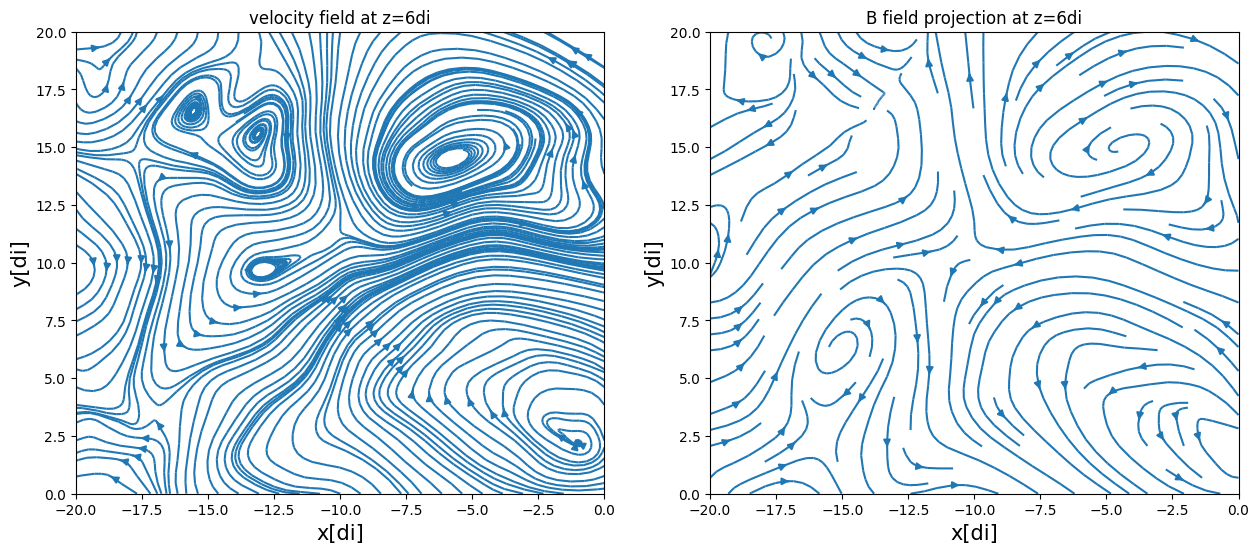

In [189]:
import matplotlib.pyplot as plt

epoch = 9
Bx, By, Bz = Q_3d['bx'][:,:,:,epoch],Q_3d['by'][:,:,:,epoch],Q_3d['bz'][:,:,:,epoch]
uix,uiy,uiz = Q_3d['uix'][:,:,:,epoch],Q_3d['uiy'][:,:,:,epoch],Q_3d['uiz'][:,:,:,epoch]
interp_Bx = RegularGridInterpolator((x, y, z), Bx)
interp_By = RegularGridInterpolator((x, y, z), By)
interp_Bz = RegularGridInterpolator((x, y, z), Bz)
interp_uix = RegularGridInterpolator((x, y, z), uix)
interp_uiy = RegularGridInterpolator((x, y, z), uiy)
interp_uiz = RegularGridInterpolator((x, y, z), uiz)
x_grid = np.linspace(-10-10,-10+10,101)
y_grid = np.linspace(10-10,10+10,100)
z_plot= 6
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='xy')
n_points = X_grid.size  # 100*100=10000
# 展平x、y网格，z固定为z_plot
points = np.column_stack([
    X_grid.ravel(),    # x坐标（展平为10000个元素）
    Y_grid.ravel(),    # y坐标（展平为10000个元素）
    np.full(n_points, z_plot)  # z坐标（全为z_plot）
]) 
Bx_flat = interp_Bx(points)  # 结果 shape: (10000,)
By_flat = interp_By(points)  # 结果 shape: (10000,)
uix_flat = interp_uix(points)  # 结果 shape: (10000,)
uiy_flat = interp_uiy(points)  # 结果 shape: (10000,)
fig,axes = plt.subplots(1,2,figsize=(15,6))

ax = axes[1]

#plt.streamplot(X_grid, Y_grid, Bx_flat.reshape(X_grid.shape), By_flat.reshape(Y_grid.shape),broken_streamlines=False, density=0.9)
ax.streamplot(X_grid, Y_grid, uix_flat.reshape(X_grid.shape), uiy_flat.reshape(Y_grid.shape))
ax.set_xlabel('x[di]', fontsize=15)
ax.set_ylabel('y[di]', fontsize=15)
ax.set_title(f'B field projection at z={z_plot}di')
ax = axes[0]

ax.streamplot(X_grid, Y_grid, Bx_flat.reshape(X_grid.shape), By_flat.reshape(Y_grid.shape),broken_streamlines=False, density=0.9)
# ax.streamplot(X_grid, Y_grid, uix_flat.reshape(X_grid.shape), uiy_flat.reshape(Y_grid.shape))
ax.set_xlabel('x[di]', fontsize=15)
ax.set_ylabel('y[di]', fontsize=15)
ax.set_title(f'velocity field at z={z_plot}di')